In [1]:
# Laden der Packages
import pandas as pd
import numpy as np
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, Dropout
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from keras.backend import binary_crossentropy
from matplotlib import pyplot as plt
from math import sqrt

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# laden der Daten
DATA_FILE="Dropbox/Masterarbeit/Masterarbeit/Datensätze/Geburtenrate/Datensatz.xlsx"
df = pd.read_excel(DATA_FILE)
df=pd.read_excel(DATA_FILE, header=0, parse_dates=[0], index_col='Jahr-Monat',squeeze=True,)

In [3]:
# Ein array mit allen Einträgen --> zur besseren Weiterverarbeitung
ZR=df.values

In [4]:
# Anteil der Datensätze am Gesamtdatensatz
ZR_100=ZR

In [5]:
# Preprocessing der Rohdaten: 100%
ZR_100new=np.atleast_2d(ZR_100)
if ZR_100new.shape[0]==1:
    ZR_100new=ZR_100new.T
nb_samples_100, nb_series_100 = ZR_100new.shape

In [6]:
# Einteilung in Trainings- und Testdaten: nicht mehr ZR sondern X --> X_train etc
test_size_100=int(0.3*nb_samples_100)
train_100, test_100 = ZR_100[:-test_size_100], ZR_100[-test_size_100:] 

In [7]:
# Shape des Input und Outputs anpassen: 100%
look_forward=240
window_size=12
# Trainingsdaten
Xtrain_100=np.atleast_3d(np.array([train_100[start:start+window_size] for start in range(0, train_100.shape[0]-(window_size+look_forward))]))
ytrain_100=train_100[window_size+look_forward:]
qtrain_100=np.atleast_3d([train_100[-(window_size):]])
print(qtrain_100.shape, ytrain_100.shape, Xtrain_100.shape)

# Testdaten
Xtest_100=np.atleast_3d(np.array([test_100[start:start+window_size] for start in range(0, test_100.shape[0]-(window_size+look_forward))]))
ytest_100=test_100[window_size+look_forward:]
qtest_100=np.atleast_3d([test_100[-(window_size):]])
print(qtest_100.shape, ytest_100.shape, Xtest_100.shape)

(1, 12, 1) (353,) (353, 12, 1)
(1, 12, 1) (6,) (6, 12, 1)


In [8]:
# Modell zusammenbauen: 
nb_filter_1=32
nb_filter_2=64
nb_filter_3=64
filter_length=2
nb_input_series=1
nb_outputs=1
model= Sequential()
model.add(Convolution1D(nb_filter=nb_filter_1, filter_length=filter_length, activation='relu', 
                        input_shape=(window_size, nb_input_series)))
model.add(Convolution1D(nb_filter=nb_filter_2, filter_length=filter_length, activation='relu'))
model.add(MaxPooling1D())
model.add(Convolution1D(nb_filter=nb_filter_3, filter_length=filter_length, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(nb_outputs, activation='linear')) 
model.compile(loss='mse', optimizer='adam', metrics=['mae']) 

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(12, 1), filters=32, kernel_size=2)`
  # Remove the CWD from sys.path while we load stuff.


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=64, kernel_size=2)`
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=64, kernel_size=2)`
  del sys.path[0]


In [9]:
# Modellzusammenfassung
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 11, 32)            96        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 64)            4160      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4, 64)             8256      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
__________

In [31]:
# Replizierbarkeit gewährleisten
np.random.seed(2)

In [32]:
# Modellanpassen: 100%
history_reg=model.fit(Xtrain_100, ytrain_100, epochs=200, batch_size=25, validation_data=(Xtest_100, ytest_100))

Train on 353 samples, validate on 6 samples
Epoch 1/200
353/353 [==============================] - 0s 575us/step - loss: 162480228.6232 - mean_absolute_error: 10077.4178 - val_loss: 81241440.0000 - val_mean_absolute_error: 7780.4805
Epoch 2/200
353/353 [==============================] - 0s 575us/step - loss: 168340561.0085 - mean_absolute_error: 10013.9567 - val_loss: 118653944.0000 - val_mean_absolute_error: 9301.6465
Epoch 3/200
353/353 [==============================] - 0s 531us/step - loss: 177149258.6969 - mean_absolute_error: 10615.2179 - val_loss: 179250704.0000 - val_mean_absolute_error: 11988.2412
Epoch 4/200
353/353 [==============================] - 0s 443us/step - loss: 170108429.5977 - mean_absolute_error: 9856.3261 - val_loss: 125891040.0000 - val_mean_absolute_error: 9703.9854
Epoch 5/200
353/353 [==============================] - 0s 443us/step - loss: 166747589.5524 - mean_absolute_error: 10263.9321 - val_loss: 134025256.0000 - val_mean_absolute_error: 10006.8652
Epoch 

Epoch 44/200
353/353 [==============================] - 0s 487us/step - loss: 157081692.7819 - mean_absolute_error: 9774.3585 - val_loss: 67078144.0000 - val_mean_absolute_error: 6982.0366
Epoch 45/200
353/353 [==============================] - 0s 575us/step - loss: 164940697.1331 - mean_absolute_error: 10033.4467 - val_loss: 94223744.0000 - val_mean_absolute_error: 8456.7842
Epoch 46/200
353/353 [==============================] - 0s 443us/step - loss: 180959303.3428 - mean_absolute_error: 10338.1189 - val_loss: 115376264.0000 - val_mean_absolute_error: 9412.1387
Epoch 47/200
353/353 [==============================] - 0s 443us/step - loss: 172732557.8130 - mean_absolute_error: 10123.9146 - val_loss: 78825136.0000 - val_mean_absolute_error: 7764.7339
Epoch 48/200
353/353 [==============================] - 0s 443us/step - loss: 156505275.2068 - mean_absolute_error: 9916.1287 - val_loss: 69871064.0000 - val_mean_absolute_error: 7168.3950
Epoch 49/200
353/353 [=============================

353/353 [==============================] - 0s 487us/step - loss: 171652680.5637 - mean_absolute_error: 10272.1106 - val_loss: 110784672.0000 - val_mean_absolute_error: 9340.3154
Epoch 88/200
353/353 [==============================] - 0s 443us/step - loss: 146390899.8414 - mean_absolute_error: 9656.4348 - val_loss: 70624840.0000 - val_mean_absolute_error: 7179.6099
Epoch 89/200
353/353 [==============================] - 0s 487us/step - loss: 179376016.0453 - mean_absolute_error: 10309.3266 - val_loss: 67400096.0000 - val_mean_absolute_error: 7084.2207
Epoch 90/200
353/353 [==============================] - 0s 487us/step - loss: 158036079.2748 - mean_absolute_error: 10061.4314 - val_loss: 141394240.0000 - val_mean_absolute_error: 10516.3096
Epoch 91/200
353/353 [==============================] - 0s 575us/step - loss: 154497679.0935 - mean_absolute_error: 9825.8197 - val_loss: 139073456.0000 - val_mean_absolute_error: 10376.7559
Epoch 92/200
353/353 [==============================] - 0s 4

Epoch 130/200
353/353 [==============================] - 0s 443us/step - loss: 139695774.1870 - mean_absolute_error: 9240.0672 - val_loss: 102988104.0000 - val_mean_absolute_error: 9067.3301
Epoch 131/200
353/353 [==============================] - 0s 487us/step - loss: 148944779.4901 - mean_absolute_error: 9536.3500 - val_loss: 118162888.0000 - val_mean_absolute_error: 9684.0576
Epoch 132/200
353/353 [==============================] - 0s 443us/step - loss: 155717183.4561 - mean_absolute_error: 9613.1033 - val_loss: 119590984.0000 - val_mean_absolute_error: 9783.3896
Epoch 133/200
353/353 [==============================] - 0s 487us/step - loss: 140030280.2493 - mean_absolute_error: 9206.9032 - val_loss: 84081960.0000 - val_mean_absolute_error: 8088.4224
Epoch 134/200
353/353 [==============================] - 0s 443us/step - loss: 158450174.2436 - mean_absolute_error: 10157.4372 - val_loss: 106088136.0000 - val_mean_absolute_error: 9063.3848
Epoch 135/200
353/353 [======================

Epoch 173/200
353/353 [==============================] - 0s 487us/step - loss: 134046254.1530 - mean_absolute_error: 9221.2656 - val_loss: 128302936.0000 - val_mean_absolute_error: 10101.4033
Epoch 174/200
353/353 [==============================] - 0s 487us/step - loss: 150524334.8045 - mean_absolute_error: 9557.0364 - val_loss: 135478032.0000 - val_mean_absolute_error: 10402.1748
Epoch 175/200
353/353 [==============================] - 0s 531us/step - loss: 153795631.6827 - mean_absolute_error: 9683.1719 - val_loss: 94791080.0000 - val_mean_absolute_error: 8675.4375
Epoch 176/200
353/353 [==============================] - 0s 487us/step - loss: 137685396.0113 - mean_absolute_error: 9139.9504 - val_loss: 82292288.0000 - val_mean_absolute_error: 8023.5024
Epoch 177/200
353/353 [==============================] - 0s 443us/step - loss: 138301304.4816 - mean_absolute_error: 9134.7043 - val_loss: 61920944.0000 - val_mean_absolute_error: 6720.2563
Epoch 178/200
353/353 [=======================

Text(0.5,1,'Loss Curves')

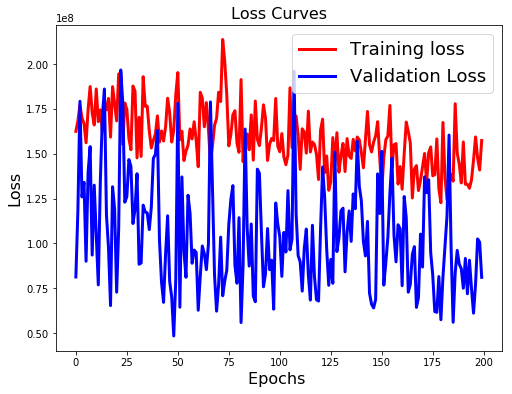

In [33]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

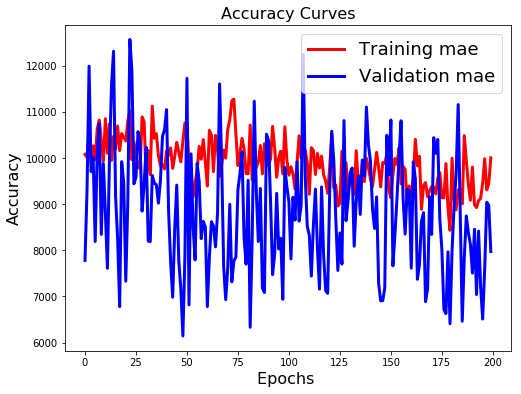

In [34]:
#Plotten der Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['mean_absolute_error'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_mean_absolute_error'],'b',linewidth=3.0)
plt.legend(['Training mae', 'Validation mae'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [35]:
# Vorhersage generieren
predictions_100 = model.predict(Xtest_100)

predictions_train_100=model.predict(Xtrain_100)

In [36]:
# Modellperformance bewerten
mse = mean_squared_error(ytest_100, predictions_100)
print('Test MSE: %.3f' % mse)

mse_train = mean_squared_error(ytrain_100, predictions_train_100)
print('Train MSE: %.3f' % mse_train)

Test MSE: 81020018.009
Train MSE: 90217441.637


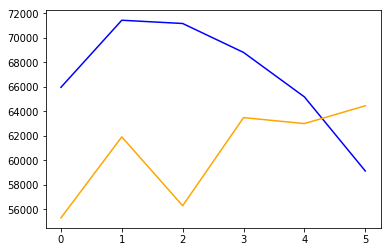

In [37]:
# Verlauf der beobachteten und vorhergesagten Werte
plt.plot(ytest_100, color='blue') 
plt.plot(predictions_100, color='orange') 
plt.show()

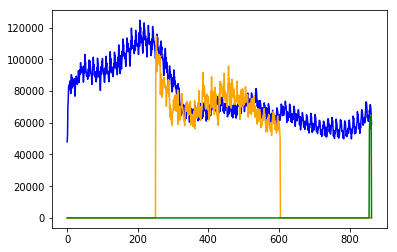

In [38]:
# Verschiebung der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_100)
trainPredictPlot[:]=[0]*len(ZR_100)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_100),1)
trainPredictPlot[(window_size+look_forward-1):len(predictions_train_100)+(window_size+look_forward-1)] = predictions_train_100


# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_100)
testPredictPlot[:]=[0]*len(ZR_100)
testPredictPlot = testPredictPlot.reshape(len(ZR_100),1)
testPredictPlot[len(predictions_train_100)+2*(window_size+look_forward)-1:len(ZR_100)-1] = predictions_100
     
       
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_100, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()